In [52]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt
from torchvision import transforms as T, datasets

In [53]:
mean=[0.4914,0.4822,0.4465]
std=[0.2470,0.2435,0.2616]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We have : {}".format(device))

We have : cuda


In [54]:
data_transforms = T.Compose([
    T.ToTensor(), # HxWxC -> CxHxW
    T.Normalize(mean=mean, std= std)
])

In [55]:
train_dataset = datasets.CIFAR10('cifa10/', train = True, download=True, transform=data_transforms)

Files already downloaded and verified


In [56]:
test_dataset = datasets.CIFAR10('cifa10/', train = False, download=False, transform=data_transforms)

In [57]:
print("Size of train set", len(train_dataset))
print("Size of test set", len(test_dataset))


Size of train set 50000
Size of test set 10000


In [88]:
class_name = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

torch.Size([32, 32, 3])


Text(0.5, 1.0, 'horse')

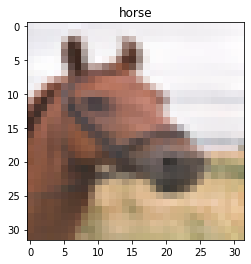

In [59]:
index = 99 
image, label = test_dataset[index]

image = image.permute(1,2,0) #CxHxW -> HxWxC

image = image * torch.Tensor(std) + torch.Tensor(mean)
print(image.shape)
plt.imshow(image)
plt.title(classes[label])

In [60]:
from torch.utils.data import DataLoader, random_split


In [61]:
train_dataset, valid_dataset = random_split(train_dataset,(45000,5000))

In [62]:
trainloader = DataLoader(train_dataset, batch_size=64, shuffle= True)
validloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [63]:
print(len(trainloader))

704


In [64]:
print(len(validloader), len(testloader))

79 157


In [65]:
dataiter = iter(trainloader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [66]:
from torch import nn 
import torch.nn.functional as F

In [67]:
class MyModel(nn.Module):

    def __init__(self):
        super(MyModel,self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = 3, out_channels= 16, kernel_size = 3, padding =1, stride = 1)
        self.conv_2 = nn.Conv2d(in_channels = 16, out_channels= 32, kernel_size = 3, padding =1, stride = 1)
        self.conv_3 = nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size = 3, padding =1, stride = 1)
        self.maxpool = nn.MaxPool2d(kernel_size =2 , stride = 2)
        self.linear_1 = nn.Linear(in_features= 1024, out_features= 500)
        self.linear_2 = nn.Linear(in_features= 500, out_features= 128)
        self.linear_3 = nn.Linear(in_features= 128, out_features= 10)
    def forward(self, images):
        a1 = self.maxpool(F.relu(self.conv_1(images)))
        a2 = self.maxpool(F.relu(self.conv_2(a1)))
        a3 = self.maxpool(F.relu(self.conv_3(a2)))
        a3 = a3.view(a3.shape[0],-1) # (bs, 64,4,4) -> (bs, 64*4*4) 
        a4 = F.relu(self.linear_1(a3))
        a5 = F.relu(self.linear_2(a4))
        a6 = F.log_softmax(self.linear_3(a5), dim =1)

        return a6


In [68]:
model = MyModel()

In [69]:
model.to(device)

MyModel(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1024, out_features=500, bias=True)
  (linear_2): Linear(in_features=500, out_features=128, bias=True)
  (linear_3): Linear(in_features=128, out_features=10, bias=True)
)

In [90]:
from torch import optim 
from torchsummary import summary
from tqdm import tqdm 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 100 
torch.backends.cudnn.benchmark = True

In [91]:
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 500]         512,500
            Linear-8                  [-1, 128]          64,128
            Linear-9                   [-1, 10]           1,290
Total params: 601,502
Trainable params: 601,502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 2.29
Estimated Total Size (MB): 2.58
-------------------------------------------

In [92]:
def accuracy(y_pred,labels):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1) 
    equals = top_class == labels.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [93]:
class Trainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                print("="*30)
                torch.save(model.state_dict(),'Cifar10Model.pt')
                valid_min_loss = avg_valid_loss # reset

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [94]:

schedular = None
print("-----Start training-----")
trainer = Trainer(criterion,optimizer, schedular)
trainer.fit(model,trainloader,validloader,epochs = epochs)

  1%|          | 6/704 [00:00<00:12, 57.30it/s]Valid_loss decreased inf --> 0.9871853159952767
Epoch : 1 Train Loss : 0.391372 Train Acc : 0.858709
Epoch : 1 Valid Loss : 0.987185 Valid Acc : 0.716772
  1%|          | 5/704 [00:00<00:16, 41.46it/s]Epoch : 2 Train Loss : 0.305819 Train Acc : 0.889537
Epoch : 2 Valid Loss : 1.088457 Valid Acc : 0.717168
  2%|▏         | 12/704 [00:00<00:12, 56.35it/s]Epoch : 3 Train Loss : 0.251183 Train Acc : 0.909357
Epoch : 3 Valid Loss : 1.203008 Valid Acc : 0.717959
  1%|          | 4/704 [00:00<00:20, 33.70it/s]Epoch : 4 Train Loss : 0.206139 Train Acc : 0.925981
Epoch : 4 Valid Loss : 1.374484 Valid Acc : 0.705103
  1%|          | 6/704 [00:00<00:12, 56.48it/s]Epoch : 5 Train Loss : 0.169138 Train Acc : 0.939542
Epoch : 5 Valid Loss : 1.485173 Valid Acc : 0.701543
  1%|          | 6/704 [00:00<00:12, 53.72it/s]Epoch : 6 Train Loss : 0.143711 Train Acc : 0.948730
Epoch : 6 Valid Loss : 1.624435 Valid Acc : 0.706487
  1%|          | 6/704 [00:00<00:

In [95]:
def view_classify(image,ps,label):
    
        classes = np.array(class_name)

        ps = ps.cpu().data.numpy().squeeze()
        
        image = image.permute(1,2,0)
        mean = torch.FloatTensor([0.485, 0.456, 0.406])
        std = torch.FloatTensor([0.229, 0.224, 0.225])
        
    
        image = image*std + mean
        img = np.clip(image,0,1)
    
        fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
        ax1.imshow(img)
        ax1.set_title('Ground Truth : {}'.format(class_name[label]))
        ax1.axis('off')
        ax2.barh(classes, ps)
        ax2.set_aspect(0.1)
        ax2.set_yticks(classes)
        ax2.set_yticklabels(classes)
        ax2.set_title('Predicted Class')
        ax2.set_xlim(0, 1.1)

        plt.tight_layout()

        return None  

In [96]:
#load model trained
model.load_state_dict(torch.load('Cifar10Model.pt', map_location= device))
model.eval() # this turns off the dropout lapyer and batch norm

avg_test_loss, avg_test_acc= trainer.valid_batch_loop(model, testloader)

print("Test Acc : {}".format(avg_test_acc))
print("Test Loss : {}".format(avg_test_loss))

100%|██████████| 157/157 [00:02<00:00, 77.32it/s]Test Acc : 0.7228304147720337
Test Loss : 0.9757313367667472



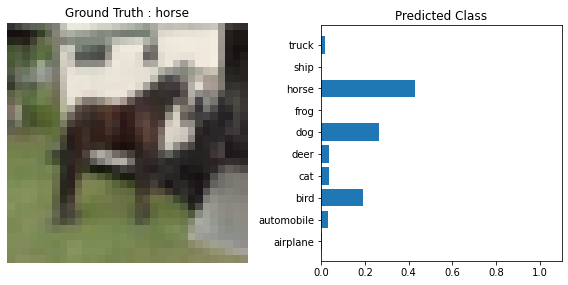

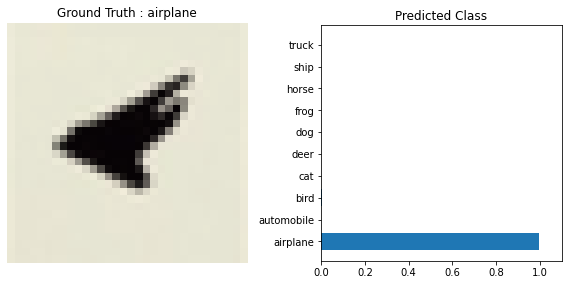

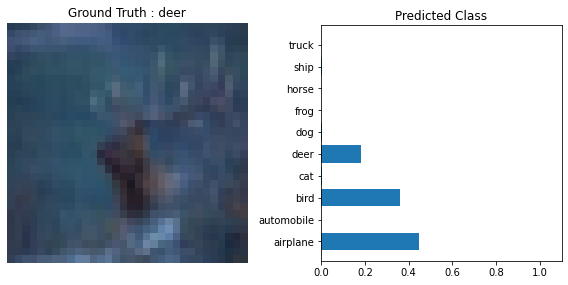

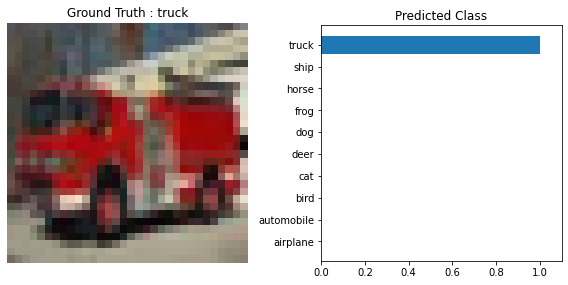

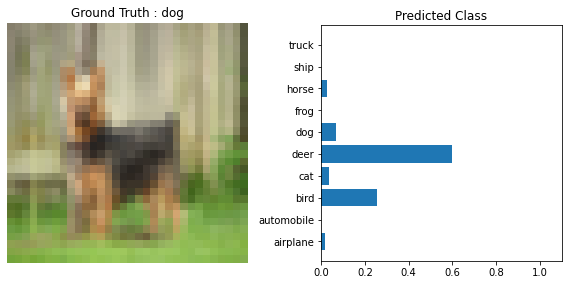

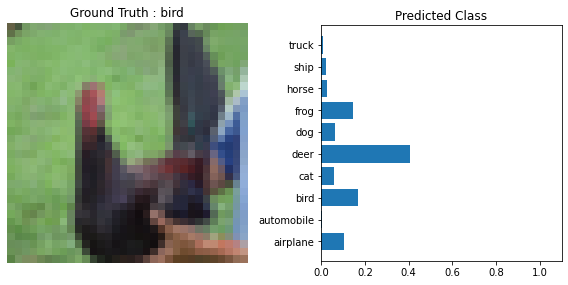

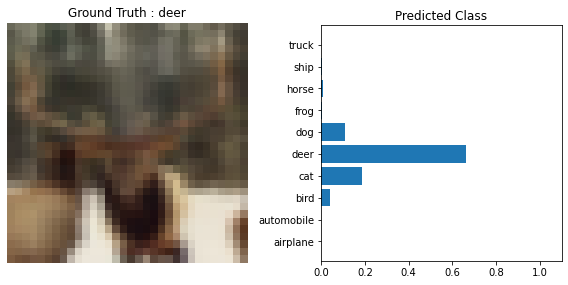

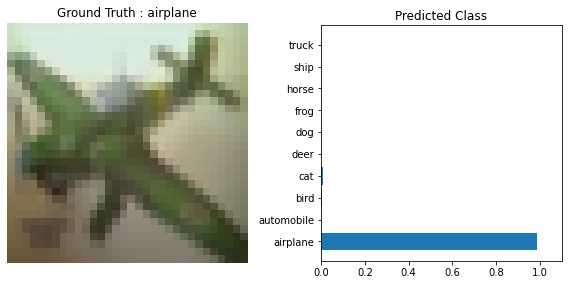

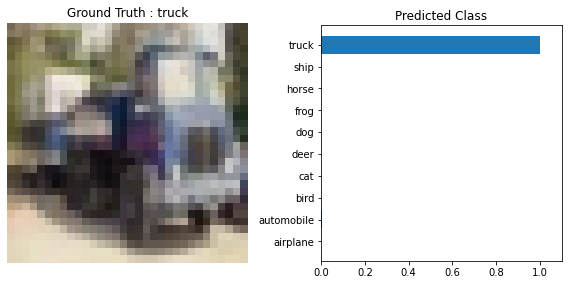

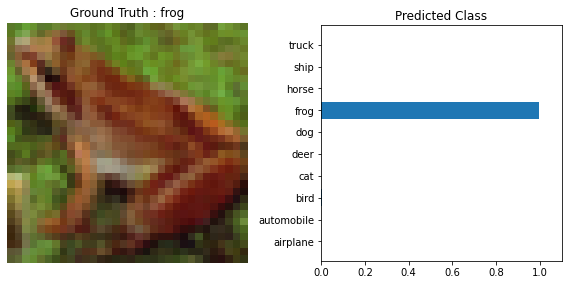

In [98]:
for i in range(20,30,1): #show 10 view_classify

    images , labels = test_dataset[i]
    logits = model(images.to(device).unsqueeze(0)) # (3,224,224) -> (1,3,224,224) and move image to device 
    ps = F.softmax(logits, dim= 1)
    view_classify(images, ps, labels)